# Assignment 3

Import required libraries

In [1]:
import torch
import random
import os
import numpy as np

In [2]:
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [3]:
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load and Prepare Data

In [4]:
import pandas
from torch.utils.data import Dataset, DataLoader

from dataset import TransliterationDataset, collate_fn

In [5]:
def prepare_data(dataset_path, batch_size=64, shuffle=True):
    dataset = TransliterationDataset(dataset_path)
    data_loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        collate_fn=collate_fn
    )

    return dataset, data_loader

In [6]:
# Dataset paths
train_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv'
val_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.dev.tsv'

# Create dataloaders
train_dataset, train_loader = prepare_data(train_path, batch_size=64)
val_dataset, val_loader = prepare_data(val_path, batch_size=64)

In [ ]:
# Model parameters
input_size = train_dataset.get_vocab_size('source')
output_size = train_dataset.get_vocab_size('target')


# Print vocabulary sizes
print(f"Source vocabulary size: {input_size}")
print(f"Target vocabulary size: {output_size}")

In [ ]:
# Model parameters
val_input_size = val_dataset.get_vocab_size('source')
val_output_size = val_dataset.get_vocab_size('target')

# Print vocabulary sizes
print(f"Validation - Source vocabulary size: {val_input_size}")
print(f"Validation - Target vocabulary size: {val_output_size}")

In [9]:
# Make sure val dataset uses the same vocabulary as training
val_dataset.source_char_to_idx = train_dataset.source_char_to_idx
val_dataset.source_idx_to_char = train_dataset.source_idx_to_char
val_dataset.target_char_to_idx = train_dataset.target_char_to_idx
val_dataset.target_idx_to_char = train_dataset.target_idx_to_char

## Train Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import trange

from vanilla_model import Encoder, Decoder, Seq2Seq
from training import train, evaluate, transliterate, calculate_accuracy

In [ ]:
def train_model(input_size, output_size, train_loader, val_loader, device, embedding_size=256, hidden_size=256, lr=0.001,
                n_layers=1, dropout=0.2, cell_type='lstm', epochs=10, teacher_forcing_ratio=0.5, clip=1.0, patience=5):  
    print(f"Using device: {device}")
    
    # Create model
    encoder = Encoder(
        input_size=input_size,
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout,
        cell_type=cell_type
    ).to(device)
    
    decoder = Decoder(
        output_size=output_size,
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout,
        cell_type=cell_type
    ).to(device)
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # # Define learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.target_char_to_idx['<PAD>'])

    best_val_loss = float('inf')
    patience_counter = 0

    # Lists to store losses
    train_losses = []
    val_losses = []
    best_model = None

    # Training loop
    print("Starting training...")
    pbar = trange(epochs, desc="Epoch", dynamic_ncols=True)
    for epoch in pbar:
        # Train
        train_loss = train(
            model=model,
            device=device,
            dataloader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            clip=clip,
            teacher_forcing_ratio=teacher_forcing_ratio
        )
        train_losses.append(train_loss)
        
        # Validate
        val_loss = evaluate(
            model=model,
            device=device,
            dataloader=val_loader,
            criterion=criterion
        )
        val_losses.append(val_loss)

        # # Update learning rate based on validation loss
        # scheduler.step(val_loss)

        # Update tqdm bar description
        pbar.set_description(f"Epoch {epoch+1}/{epochs}")
        pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")
            
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            torch.save(model.state_dict(), 'best_vanilla_model.pth')
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs!")
            break
    
    print("best model saved at: best_vanilla_model.pth")

    return train_losses, val_losses, best_model

In [ ]:
train_losses, val_losses, best_model = train_model(input_size=input_size, output_size=output_size, train_loader=train_loader, 
                                       val_loader=val_loader, device=device)

### Visualize training results

In [7]:
import matplotlib.pyplot as plt

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
# plt.savefig('loss_plot.png')

## Hyperparameter Tuning with Wandb

In [8]:
import wandb

In [9]:
BEST_VAL_LOSS = float('inf')
BEST_VAL_ACC = 0

In [ ]:
# Train the model with wandb integration
def train_with_wandb(config=None):
    global BEST_VAL_LOSS, BEST_VAL_ACC
    
    # Initialize a new wandb run
    with wandb.init(config=config) as run:
        # If called by wandb.agent, use the config set by sweep controller
        config = wandb.config
        
        # Generate a descriptive name for the run based on key hyperparameters
        run_name = (
            f"ct{config.cell_type}-tfr{config.teacher_forcing_ratio}-lr{config.learning_rate}-es{config.embedding_size}-hs{config.hidden_size}-"
            f"nl{config.num_layers}-d{config.dropout}-bs{config.batch_size}"
        )
        
        run.name = run_name
        
        # Access hyperparameters as wandb.config
        config = wandb.config
        
        # Set seed
        set_seed(config.seed)
        
        # Device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Create save directory if it doesn't exist
        if not os.path.exists('models'):
            os.makedirs('models')
        
        # Dataset paths
        train_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv'
        val_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.dev.tsv'

        # Create dataloaders
        train_dataset, train_loader = prepare_data(train_path, batch_size=config.batch_size)
        val_dataset, val_loader = prepare_data(val_path, batch_size=config.batch_size)

        # Make sure val dataset uses the same vocabulary as training
        val_dataset.source_char_to_idx = train_dataset.source_char_to_idx
        val_dataset.source_idx_to_char = train_dataset.source_idx_to_char
        val_dataset.target_char_to_idx = train_dataset.target_char_to_idx
        val_dataset.target_idx_to_char = train_dataset.target_idx_to_char
        
        # Create model
        encoder = Encoder(
            input_size=train_dataset.get_vocab_size('source'),
            embedding_size=config.embedding_size,
            hidden_size=config.hidden_size,
            n_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )
        
        decoder = Decoder(
            output_size=train_dataset.get_vocab_size('target'),
            embedding_size=config.embedding_size,
            hidden_size=config.hidden_size,
            n_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )
        
        model = Seq2Seq(encoder, decoder, device).to(device)
        
        # Optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.target_char_to_idx['<PAD>'])
        
        # Train model
        best_val_loss = float('inf')
        best_val_acc = 0
        patience = config.patience
        patience_counter = 0

        pbar = trange(int(config.epochs), desc="Epoch", dynamic_ncols=True)
        for epoch in pbar:
            # Train
            train_loss = train(
                model, device, train_loader, optimizer, criterion, 
                clip=config.clip, teacher_forcing_ratio=config.teacher_forcing_ratio
            )
            
            # Evaluate
            val_loss = evaluate(model, device, val_loader, criterion=criterion)

            # Evaluate accuracy on validation set
            correct = 0
            total = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    source_texts = batch['source_text']
                    target_texts = batch['target_text']
                    
                    for i, source_text in enumerate(source_texts):
                        pred_text = transliterate(model, device, val_dataset, source_text)
                        
                        if pred_text == target_texts[i]:
                            correct += 1
                        total += 1
            
            val_acc = correct / total

            # Update tqdm bar description
            pbar.set_description(f"Epoch {epoch+1}/{config.epochs}")
            pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}", val_acc=f"{val_acc:.4f}")
            
            # Log to wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy':val_acc
            })

            # Save best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                model_path = os.path.join('models', f'model_{wandb.run.id}.pth')
                torch.save(model.state_dict(), model_path)

                if best_val_loss < BEST_VAL_LOSS:
                    BEST_VAL_LOSS = best_val_loss
                    BEST_VAL_ACC = best_val_acc
                    torch.save(model.state_dict(), "best_vanilla_model.pth")
                    
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs!")
                break

        # # Load best model for final evaluation
        # model.load_state_dict(torch.load(os.path.join('models', f'model_{wandb.run.id}.pth')))
        
        # # Evaluate accuracy on validation set
        # correct = 0
        # total = 0
        
        # with torch.no_grad():
        #     for batch in val_loader:
        #         source_texts = batch['source_text']
        #         target_texts = batch['target_text']
                
        #         for i, source_text in enumerate(source_texts):
        #             pred_text = transliterate(best_model, device, val_dataset, source_text)
                    
        #             if pred_text == target_texts[i]:
        #                 correct += 1
        #             total += 1
        
        # val_accuracy = correct / total
        # print(f'Validation Accuracy: {val_accuracy:.3f}')
        
        # print(f"\tBest model saved with val loss {best_val_loss:.3f} at model_{wandb.run.id}.pth")
        print(f"\tBest model saved with val acc {best_val_acc:.3f} at model_{wandb.run.id}.pth")

        # Log final metrics
        wandb.log({
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc
        })

In [11]:
# Define sweep configuration
sweep_config = {
    'method': 'bayes',
    'name': 'sweep_vanilla',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'seed': {
            'value': 42
        },
        'learning_rate': {
           'min': 0.0001, 
           'max': 0.01
        },
        'batch_size': {
            'values': [32, 64]
        },
        'embedding_size': {
            'values': [64, 128, 256]
        },
        'hidden_size': {
            'values': [128, 256]
        },
        'num_layers': {
            'values': [1, 2]
        },
        'dropout': {
            'values': [0.1, 0.3]
        },
        'cell_type': {
            'values': ['rnn', 'lstm', 'gru']
        },
        'teacher_forcing_ratio': {
            'values': [0.5, 0.7]
        },
        'clip': {
            'value': 1.0
        },
        'epochs': {
            'value': 20
        },
        'patience': {
            'value': 5
        }
    }
}

In [12]:
os.environ["WANDB_NOTEBOOK_NAME"] = "vanilla.ipynb"

wandb.login()

wandb: Currently logged in as: ch21b021 (ch21b021-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='DA6401-Assignment-3')

# Run the sweep
wandb.agent(sweep_id, train_with_wandb, count=15)

Create sweep with ID: rb9v6cga
Sweep URL: https://wandb.ai/ch21b021-indian-institute-of-technology-madras/DA6401-Assignment-3/sweeps/rb9v6cga


wandb: Agent Starting Run: met6m9h1 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.008862437573169575
wandb: 	num_layers: 2
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 10/20:  50%|█████     | 10/20 [22:20<22:09, 132.93s/it, train_loss=0.7445, val_acc=0.2239, val_loss=1.4353]

In [17]:
def analyze_errors(predictions):
    """
    Analyze the errors made by the model
    """
    # Count total predictions and correct predictions
    total = len(predictions)
    correct = sum(1 for _, pred, target in predictions if pred == target)
    
    print(f'Accuracy: {correct/total:.3f} ({correct}/{total})')
    
    # Analyze error patterns
    errors = [(source, pred, target) for source, pred, target in predictions if pred != target]
    
    # Error by length
    length_errors = {}
    for source, _, target in errors:
        length = len(source)
        if length not in length_errors:
            length_errors[length] = 0
        length_errors[length] += 1
    
    # Sort by length
    sorted_length_errors = {k: v for k, v in sorted(length_errors.items())}
    
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_length_errors.keys(), sorted_length_errors.values())
    plt.xlabel('Source Length')
    plt.ylabel('Number of Errors')
    plt.title('Errors by Source Length')
    plt.savefig('predictions_vanilla/errors_by_length.png')
    
    # Sample error analysis
    print("\nSample Error Analysis:")
    for i, (source, pred, target) in enumerate(errors[:10]):
        print(f'Source: {source}')
        print(f'Prediction: {pred}')
        print(f'Target: {target}')
        print()

In [35]:
def test_best_model(best_config, model_path):
    # Load datasets
    train_dataset_path = "dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv"
    test_dataset_path = "dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.test.tsv"
    
    train_dataset, _ = prepare_data(train_dataset_path, batch_size=best_config['batch_size'], shuffle=False)
    test_dataset, test_dataloader = prepare_data(test_dataset_path, batch_size=best_config['batch_size'], shuffle=False)
    
    # Make sure test dataset uses the same vocabulary as training
    test_dataset.source_char_to_idx = train_dataset.source_char_to_idx
    test_dataset.source_idx_to_char = train_dataset.source_idx_to_char
    test_dataset.target_char_to_idx = train_dataset.target_char_to_idx
    test_dataset.target_idx_to_char = train_dataset.target_idx_to_char

    # Initialize model with best configuration
    input_size = train_dataset.get_vocab_size('source')
    output_size = train_dataset.get_vocab_size('target')
        
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")    

    best_encoder = Encoder(
        input_size=input_size, 
        embedding_size=best_config['embedding_size'], 
        hidden_size=best_config['hidden_size'], 
        n_layers=best_config['num_layers'], 
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    best_decoder = Decoder(
        output_size=output_size, 
        embedding_size=best_config['embedding_size'], 
        hidden_size=best_config['hidden_size'], 
        n_layers=best_config['num_layers'], 
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    best_model = Seq2Seq(best_encoder, best_decoder, device).to(device)
    
    # Load model parameters
    best_model.load_state_dict(torch.load(model_path))
    
    # Evaluate on test set
    test_accuracy, test_predictions = calculate_accuracy(best_model, device, test_dataloader, train_dataset)
    
    print(f'Test Accuracy: {test_accuracy:.3f}')
    
    # Save predictions to file
    with open('predictions_vanilla/test_predictions.txt', 'w', encoding='utf-8') as f:
        for source, pred, target in test_predictions:
            f.write(f'Source: {source}\n')
            f.write(f'Prediction: {pred}\n')
            f.write(f'Target: {target}\n\n')
    
    # Create error analysis
    analyze_errors(test_predictions)
    
    return test_predictions

In [31]:
best_config = {'embedding_size': 256, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.1, 'cell_type': 'rnn', 'batch_size': 64}

best_model_path = "models/model_0bp4kcni.pth"

In [36]:
# Make sure predictions directory exists
os.makedirs('predictions_vanilla', exist_ok=True)

Using device: cuda
Test Accuracy: 0.000
Accuracy: 0.000 (0/5610)

Sample Error Analysis:
Source: adisthaanamaakkiyaanu
Prediction: സ്ക്
Target: അടിസ്ഥാനമാക്കിയാണ്

Source: atisthaanamaakkiyaanu
Prediction: സ്ക്
Target: അടിസ്ഥാനമാക്കിയാണ്

Source: adisthaanamaakkiya
Prediction: സ്ക്
Target: അടിസ്ഥാനമാക്കിയ

Source: atisthaanamaakkiya
Prediction: സ്ക്
Target: അടിസ്ഥാനമാക്കിയ

Source: adangunnathaanu
Prediction: സ്ക്
Target: അടങ്ങുന്നതാണ്

Source: amgeekarikkuka
Prediction: സ്ക്
Target: അംഗീകരിക്കുക

Source: angeekarikkuka
Prediction: സ്ക്
Target: അംഗീകരിക്കുക

Source: adangunnathaan
Prediction: സ്ക്
Target: അടങ്ങുന്നതാണ്

Source: atangunnathaan
Prediction: സ്ക്
Target: അടങ്ങുന്നതാണ്

Source: adayaalamaayi
Prediction: സ്ക്
Target: അടയാളമായി



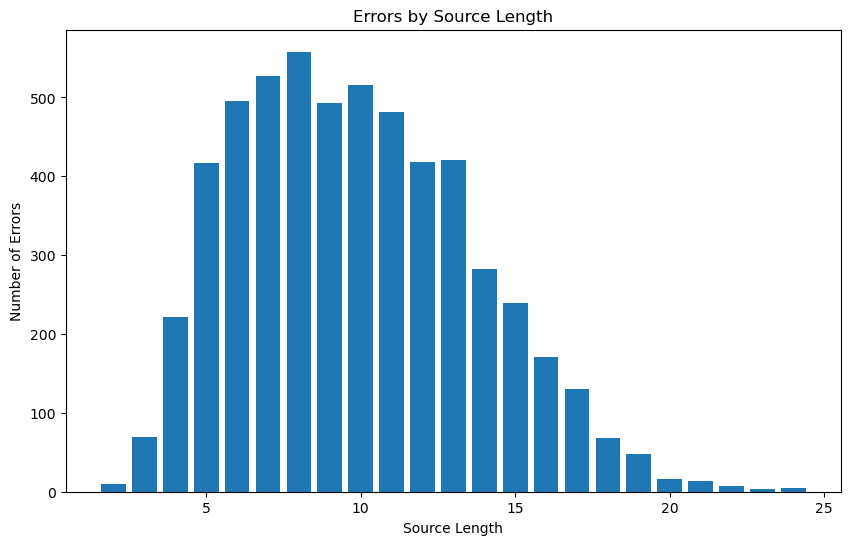

In [36]:
# Test best model
test_predictions = test_best_model(best_config, best_model_path)